In [ ]:
import os
os.environ['TRKXINPUTDIR'] = '/global/cfs/cdirs/m3443/data/trackml-kaggle/train_all' # better change to your copy of the dataset.
os.environ['TRKXOUTPUTDIR'] = '/global/cscratch1/sd/xju/heptrkx/iml2020/run200' # change to your own directory

In [2]:
# system import
import pkg_resources
import yaml
import pprint
import random
random.seed(1234)
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
# %matplotlib widget

# 3rd party
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from trackml.dataset import load_event
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint


# local import
# from heptrkx.dataset import event as master
from exatrkx import config_dict # for accessing predefined configuration files
from exatrkx import outdir_dict # for accessing predefined output directories
from exatrkx.src import utils_dir


# for preprocessing
from exatrkx import FeatureStore
from exatrkx.src import utils_torch

# for embedding
from exatrkx import LayerlessEmbedding
from exatrkx.src import utils_torch

# for filtering
from exatrkx import VanillaFilter

# for GNN
import tensorflow as tf
from graph_nets import utils_tf
from exatrkx import SegmentClassifier
import sonnet as snt

# for labeling
from exatrkx.scripts.tracks_from_gnn import prepare as prepare_labeling
from exatrkx.scripts.tracks_from_gnn import clustering as dbscan_clustering

# track efficiency
from trackml.score import _analyze_tracks
from exatrkx.scripts.eval_reco_trkx import make_cmp_plot, pt_configs, eta_configs
from functools import partial

### Setup some hyperparameters and event

In [3]:
embed_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/embedding/checkpoints/epoch=10.ckpt'
filter_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/filtering/checkpoints/epoch=92.ckpt'
gnn_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/gnn'
plots_dir = '/global/cscratch1/sd/xju/heptrkx/iml2020/run200' # needs to change...
ckpt_idx = -1 # which GNN checkpoint to load
dbscan_epsilon, dbscan_minsamples = 0.25, 2 # hyperparameters for DBScan
min_hits = 5 # minimum number of hits associated with a particle to define "reconstructable particles"
frac_reco_matched, frac_truth_matched = 0.5, 0.5 # parameters for track matching

In [4]:
evtid = 1000
event_file = os.path.join(utils_dir.inputdir, 'event{:09}'.format(evtid))

### Preprocessing

In [5]:
action = 'build'

config_file = pkg_resources.resource_filename(
                    "exatrkx",
                    os.path.join('configs', config_dict[action]))
with open(config_file) as f:
    b_config = yaml.load(f, Loader=yaml.FullLoader)
    
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(b_config)

{   'adjacent': True,
    'cell_information': True,
    'endcaps': False,
    'layerless': True,
    'layerwise': False,
    'n_files': 10,
    'n_tasks': 1,
    'n_workers': 2,
    'noise': False,
    'pt_min': 1}


In [6]:
b_config['pt_min'] = 0
b_config['endcaps'] = True
b_config['n_workers'] = 1
b_config['n_files'] = 1

In [7]:
# this cell is only needed for the first run to prodcue the dataset
preprocess_dm = FeatureStore(b_config)
preprocess_dm.prepare_data()

Loading detector...
Detector loaded.
Writing outputs to /global/cscratch1/sd/xju/heptrkx/iml2020/run200/feature_store
Preparing 1000
Layerless truth graph built for /global/cfs/cdirs/m3443/data/trackml-kaggle/train_all/event000001000 with size (2, 123429)
Cell features for 1000
Loading event /global/cfs/cdirs/m3443/data/trackml-kaggle/train_all/event000001000 with a 0 pT cut
Writing to  /global/cscratch1/sd/xju/heptrkx/iml2020/run200/feature_store/1000


### Read the preprocessed data

In [8]:
data = torch.load(os.path.join(utils_dir.feature_outdir, str(evtid)))
data

Data(cell_data=[103305, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_all/event000001000", hid=[103305], layerless_true_edges=[2, 123429], layers=[103305], pid=[103305], x=[103305, 3])

### Evaluating Embedding

In [9]:
e_ckpt = torch.load(embed_ckpt_dir, map_location='cpu')
e_config = e_ckpt['hyper_parameters']
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(e_config)

{   'adjacent': False,
    'emb_dim': 8,
    'emb_hidden': 512,
    'endcaps': True,
    'factor': 0.3,
    'in_channels': 12,
    'input_dir': '/global/cscratch1/sd/danieltm/ExaTrkX/trackml/feature_store_endcaps',
    'knn': 20,
    'layerless': True,
    'layerwise': False,
    'lr': 0.002,
    'margin': 1,
    'max_epochs': 100,
    'nb_layer': 6,
    'noise': False,
    'output_dir': 'global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/embedding_processed/0_pt_cut_endcaps',
    'overwrite': True,
    'patience': 5,
    'project': 'EmbeddingStudy',
    'pt_min': 0,
    'r_train': 1,
    'r_val': 0.5,
    'randomisation': 2,
    'regime': ['rp', 'hnm', 'ci'],
    'train_split': [900, 50, 50],
    'wandb_save_dir': '/global/cscratch1/sd/danieltm/ExaTrkX/wandb_data',
    'warmup': 500,
    'weight': 4}


In [10]:
e_config = e_ckpt['hyper_parameters']
e_config['clustering'] = 'build_edges'
e_config['knn_val'] = 500
e_config['r_val'] = 1.7

Load the checkpoint and put the model in the evaluation state.

In [11]:
e_model = LayerlessEmbedding(e_config)
e_model.load_state_dict(e_ckpt["state_dict"])

<All keys matched successfully>

In [12]:
e_model.eval()

LayerlessEmbedding(
  (layers): ModuleList(
    (0): Linear(in_features=12, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
  )
  (emb_layer): Linear(in_features=512, out_features=8, bias=True)
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (act): Tanh()
)

Map each hit to the embedding space, return the embeded parameters for each hit

In [13]:
%%time
spatial = e_model(torch.cat([data.cell_data, data.x], axis=-1))

CPU times: user 25.1 s, sys: 3.01 s, total: 28.1 s
Wall time: 878 ms


### From embeddeding space form doublets

`r_val = 1.7` and `knn_val = 500` are the hyperparameters to be studied.

* `r_val` defines the radius of the clustering method
* `knn_val` defines the number of maximum neighbors in the embedding space

In [14]:
%%time
e_spatial = utils_torch.build_edges(spatial, e_model.hparams['r_val'], e_model.hparams['knn_val'])

CPU times: user 3min 38s, sys: 3.88 s, total: 3min 41s
Wall time: 6.99 s


In [15]:
e_spatial = e_spatial.cpu().numpy()

Removing edges that point from outer region to inner region, which almost removes half of edges.

In [16]:
R_dist = torch.sqrt(data.x[:,0]**2 + data.x[:,2]**2) # distance away from origin...
e_spatial = e_spatial[:, (R_dist[e_spatial[0]] <= R_dist[e_spatial[1]])]

### Filtering


In [17]:
f_ckpt = torch.load(filter_ckpt_dir, map_location='cpu')
f_config = f_ckpt['hyper_parameters']
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(f_config)

{   'adjacent': False,
    'batchnorm': False,
    'callbacks': [],
    'emb_channels': 0,
    'endcaps': True,
    'factor': 0.3,
    'filter_cut': 0.3,
    'hidden': 512,
    'in_channels': 12,
    'input_dir': '/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/embedding_processed/0_pt_cut_endcaps',
    'layerless': True,
    'layernorm': True,
    'layerwise': False,
    'lr': 0.002,
    'max_epochs': 100,
    'nb_layer': 3,
    'noise': False,
    'output_dir': '/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/filter_processed/0_pt_cut_endcaps',
    'patience': 8,
    'project': 'FilteringStudy',
    'pt_min': 0,
    'ratio': 2,
    'regime': ['ci'],
    'train_split': [80, 10, 10],
    'val_subset': 0.1,
    'wandb_save_dir': '/global/cscratch1/sd/danieltm/ExaTrkX/wandb_data',
    'warmup': 200,
    'weight': 2}


In [18]:
f_config['train_split'] = [0, 0, 1]
f_config['filter_cut'] = 0.18

In [19]:
f_model = VanillaFilter(f_config)
# f_model = f_model.load_from_checkpoint(filter_ckpt_dir, hparams=f_config)
f_model.load_state_dict(f_ckpt['state_dict'])

<All keys matched successfully>

In [20]:
f_model.eval()

VanillaFilter(
  (input_layer): Linear(in_features=24, out_features=512, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (output_layer): Linear(in_features=512, out_features=1, bias=True)
  (layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (batchnorm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (act): Tanh()
)

In [21]:
%%time
#emb = None # embedding information was not used in the filtering stage.
#output = f_model(torch.cat([data.cell_data, data.x], axis=-1), e_spatial, emb).squeeze()

CPU times: user 8min 20s, sys: 3min 35s, total: 11min 56s
Wall time: 25.5 s


In [ ]:
%%time
emb = None # embedding information was not used in the filtering stage.
chunks = 8
output_list = []
for j in range(chunks):
    subset_ind = torch.chunk(torch.arange(e_spatial.shape[1]), chunks)[j]
    with torch.no_grad():
        output = f_model(torch.cat([data.cell_data, data.x], axis=-1).to(device), e_spatial[:, subset_ind], emb).squeeze() 
    output_list.append(output)
    del subset_ind
    del output
    gc.collect()
output = torch.cat(output_list)

In [22]:
output = torch.sigmoid(output)

In [23]:
output.shape, e_spatial.shape

(torch.Size([10048694]), (2, 10048694))

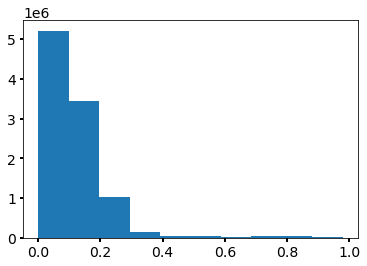

In [24]:
# this plot may need some time to load...
plt.hist(output.detach().numpy(), );

The filtering network assigns a score to each edge. In the end, edges with socres > `filter_cut` are selected to construct graphs.

In [25]:
edge_list = e_spatial[:, output > f_model.hparams['filter_cut']]

In [26]:
edge_list.shape

(2, 1740231)

### Form a graph
Now moving TensorFlow for GNN inference.

In [27]:
n_nodes = data.x.shape[0]
n_edges = edge_list.shape[1]
nodes = data.x.numpy().astype(np.float32)
edges = np.zeros((n_edges, 1), dtype=np.float32)
senders = edge_list[0]
receivers = edge_list[1]

In [28]:
input_datadict = {
    "n_node": n_nodes,
    "n_edge": n_edges,
    "nodes": nodes,
    "edges": edges,
    "senders": senders,
    "receivers": receivers,
    "globals": np.array([n_nodes], dtype=np.float32)
}

In [29]:
input_graph = utils_tf.data_dicts_to_graphs_tuple([input_datadict])

### Apply GNN

In [30]:
num_processing_steps_tr = 8
optimizer = snt.optimizers.Adam(0.001)
model = SegmentClassifier()

output_dir = gnn_ckpt_dir
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
ckpt_manager = tf.train.CheckpointManager(checkpoint, directory=output_dir, max_to_keep=10)
status = checkpoint.restore(ckpt_manager.checkpoints[ckpt_idx])
print("Loaded {} checkpoint from {}".format(ckpt_idx, output_dir))

Loaded -1 checkpoint from /global/cfs/cdirs/m3443/data/lightning_models/gnn


In [31]:
%%time
outputs_gnn = model(input_graph, num_processing_steps_tr)
output_graph = outputs_gnn[-1]

CPU times: user 46.2 s, sys: 2min 6s, total: 2min 52s
Wall time: 7.51 s


### Track labeling

In [32]:
input_matrix = prepare_labeling(tf.squeeze(output_graph.edges).numpy(), senders, receivers, n_nodes)

In [33]:
predict_tracks = dbscan_clustering(data.hid, input_matrix, dbscan_epsilon, dbscan_minsamples)

/global/homes/x/xju/.conda/envs/tf2.3/lib/python3.8/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn('Precomputed sparse input was not sorted by data.',


### Track Efficiency

In [34]:
hits, particles, truth = load_event(event_file, parts=['hits', 'particles', 'truth'])
hits = hits.merge(truth, on='hit_id', how='left')
hits = hits[hits.particle_id > 0] # remove noise hits
hits = hits.merge(particles, on='particle_id', how='left')
hits = hits[hits.nhits >= min_hits]
particles = particles[particles.nhits >= min_hits]
par_pt = np.sqrt(particles.px**2 + particles.py**2)
momentum = np.sqrt(particles.px**2 + particles.py**2 + particles.pz**2)
ptheta = np.arccos(particles.pz/momentum)
peta = -np.log(np.tan(0.5*ptheta))

In [35]:
tracks = _analyze_tracks(hits, predict_tracks)

In [36]:
purity_rec = np.true_divide(tracks['major_nhits'], tracks['nhits'])
purity_maj = np.true_divide(tracks['major_nhits'], tracks['major_particle_nhits'])
good_track = (frac_reco_matched < purity_rec) & (frac_truth_matched < purity_maj)

matched_pids = tracks[good_track].major_particle_id.values
score = tracks['major_weight'][good_track].sum()

n_recotable_trkx = particles.shape[0]
n_reco_trkx = tracks.shape[0]
n_good_recos = np.sum(good_track)
matched_idx = particles.particle_id.isin(matched_pids).values

In [37]:
print("Processed {} events from {}".format(evtid, utils_dir.inputdir))
print("Reconstructable tracks:         {}".format(n_recotable_trkx))
print("Reconstructed tracks:           {}".format(n_reco_trkx))
print("Reconstructable tracks Matched: {}".format(n_good_recos))
print("Tracking efficiency:            {:.4f}".format(n_good_recos/n_recotable_trkx))
print("Tracking purity:               {:.4f}".format(n_good_recos/n_reco_trkx))

Processed 1000 events from /global/cfs/cdirs/m3443/data/trackml-kaggle/train_all
Reconstructable tracks:         8963
Reconstructed tracks:           13890
Reconstructable tracks Matched: 8153
Tracking efficiency:            0.9096
Tracking purity:               0.5870


In [38]:
make_cmp_plot_fn = partial(make_cmp_plot, xlegend="Matched", ylegend="Reconstructable",
                    ylabel="Events", ratio_label='Track efficiency')

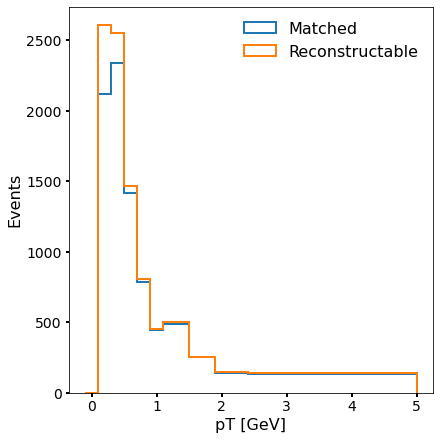

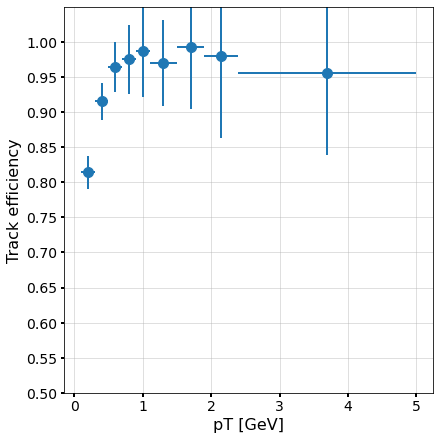

In [39]:
make_cmp_plot_fn(par_pt[matched_idx], par_pt,
                 configs=pt_configs,
                 xlabel="pT [GeV]",
                 outname=os.path.join(plots_dir, "{}_pt".format(evtid)))

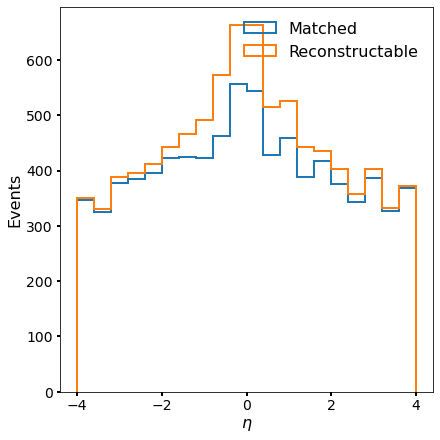

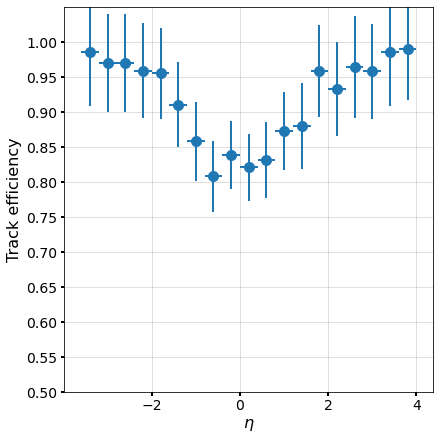

In [40]:
make_cmp_plot_fn(peta[matched_idx], peta,
                 configs=eta_configs,
                 xlabel=r"$\eta$",
                 outname=os.path.join(plots_dir, "{}_eta".format(evtid)))